In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import confusion_matrix
np.random.seed(1)

In [2]:
data = pd.read_csv('train.csv')

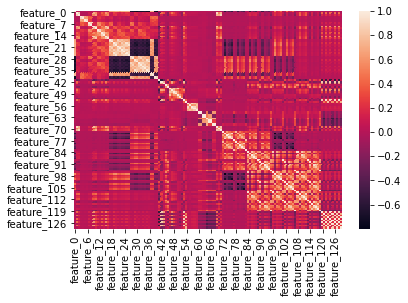

In [3]:
features = ['feature_' + str(i) for i in range(130)]
corr = data[features].corr()
sns.heatmap(corr)

In [6]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.8:
            if columns[j]:
                columns[j] = False
selected_columns = data[features].columns[columns]
len(selected_columns)

55

In [8]:
import statsmodels.api as sm
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        print(i, numVars, i / numVars)
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns
SL = 0.05
data_modeled, selected_columns = backwardElimination(data.dropna()[selected_columns].values, data.dropna()['resp'].values, SL, selected_columns)

0 55 0.01818181818181818
1 55 0.01818181818181818
2 55 0.01818181818181818
3 55 0.01818181818181818
4 55 0.01818181818181818
5 55 0.01818181818181818
6 55 0.01818181818181818
7 55 0.01818181818181818
8 55 0.01818181818181818
9 55 0.01818181818181818
10 55 0.01818181818181818
11 55 0.01818181818181818
12 55 0.01818181818181818
13 55 0.01818181818181818
14 55 0.01818181818181818
15 55 0.01818181818181818
16 55 0.01818181818181818
17 55 0.01818181818181818
18 55 0.01818181818181818
19 55 0.01818181818181818
20 55 0.01818181818181818
21 55 0.01818181818181818
22 55 0.01818181818181818
23 55 0.01818181818181818
24 55 0.01818181818181818
25 55 0.01818181818181818
26 55 0.01818181818181818
27 55 0.01818181818181818
28 55 0.01818181818181818
29 55 0.01818181818181818
30 55 0.01818181818181818
31 55 0.01818181818181818
32 55 0.01818181818181818
33 55 0.01818181818181818
34 55 0.01818181818181818
35 55 0.01818181818181818
36 55 0.01818181818181818
37 55 0.01818181818181818
38 55 0.01818181818181

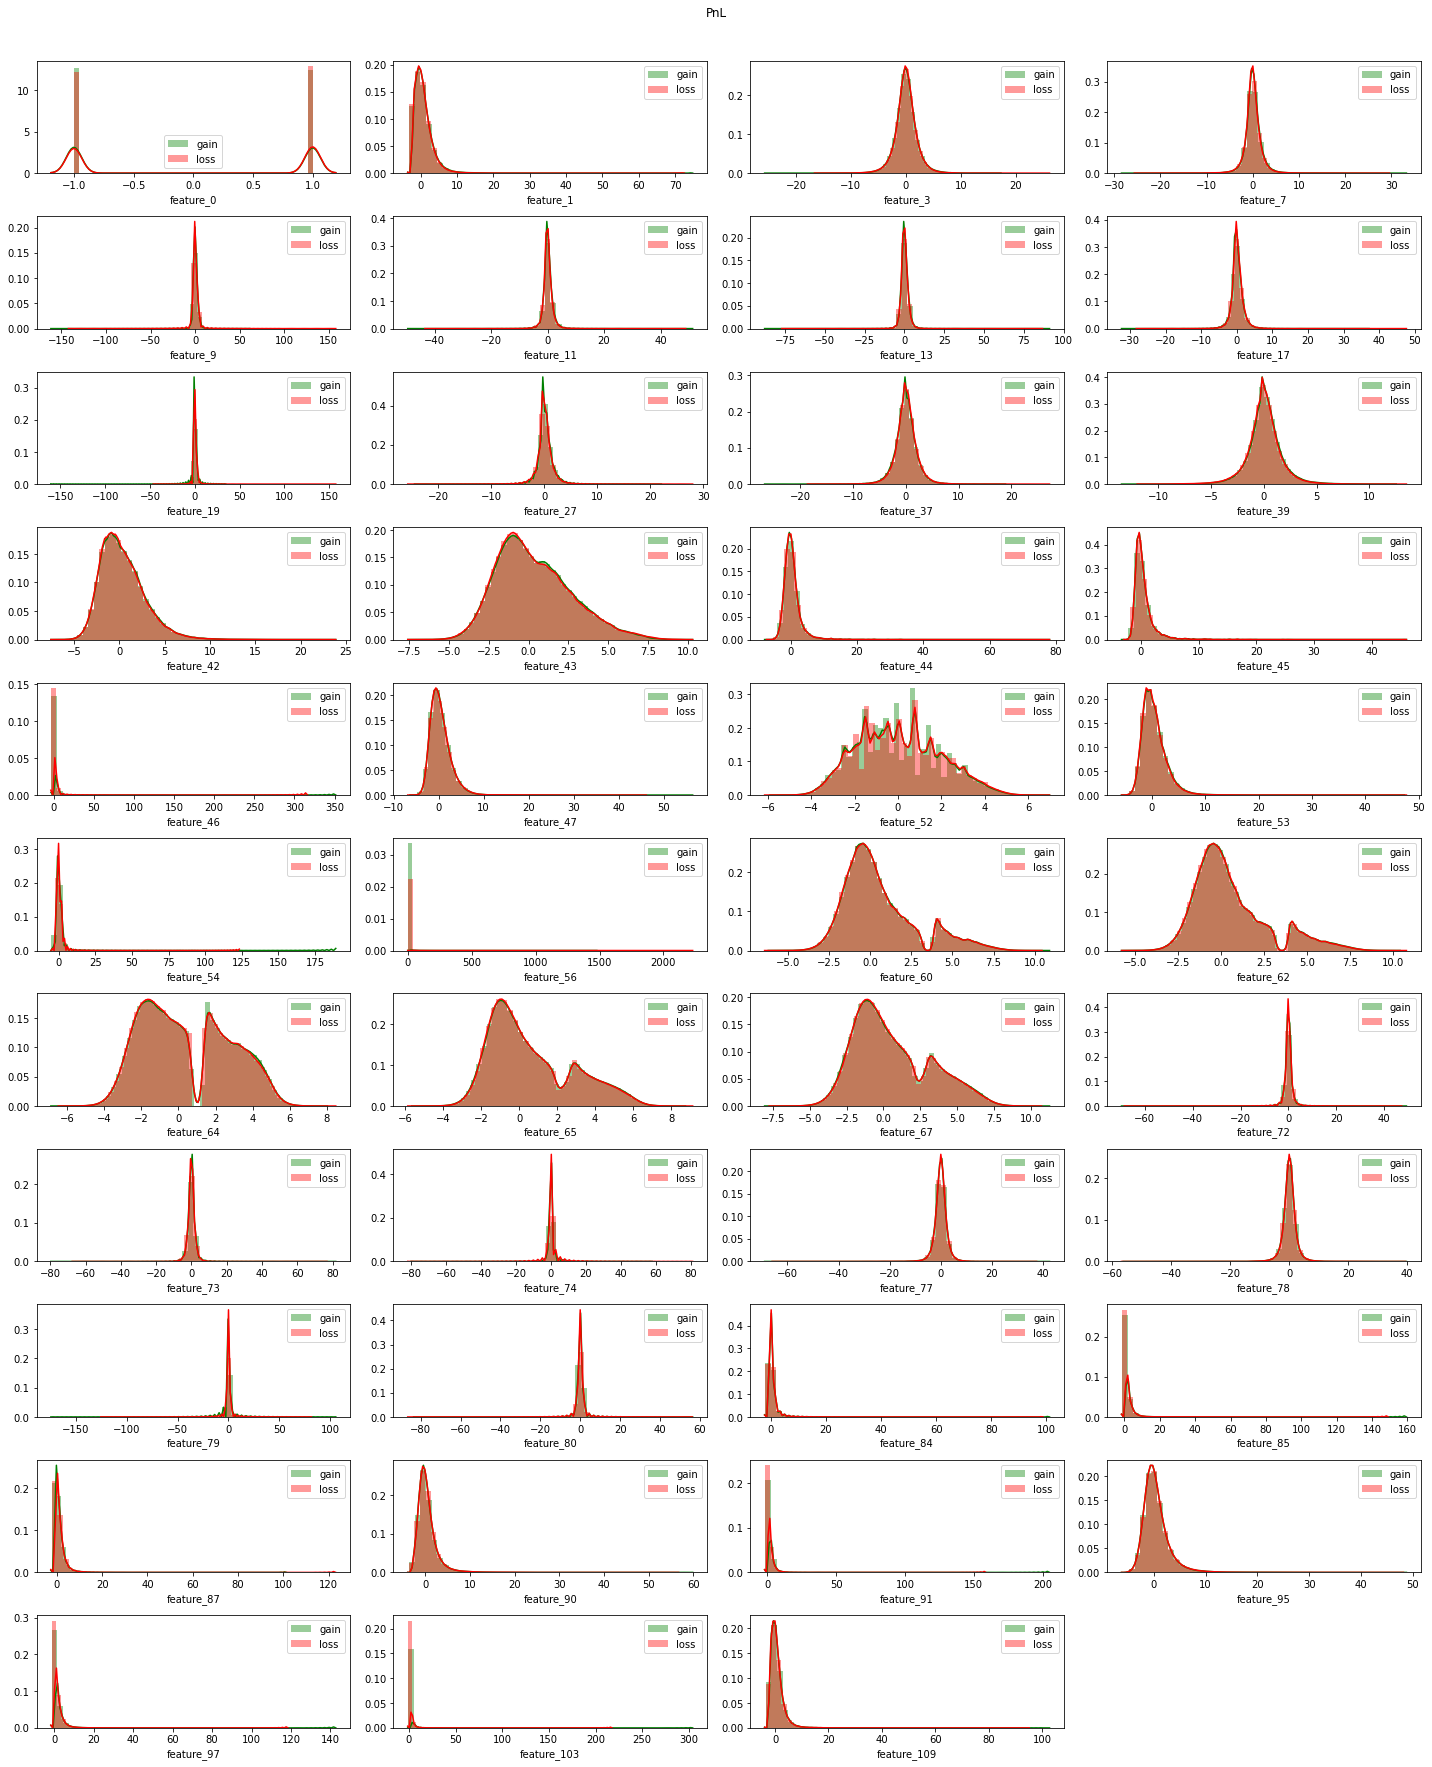

In [12]:
result = pd.DataFrame()
result['pnl'] = data['resp']

fig = plt.figure(figsize = (20, 25))
j = 0
for i in data[selected_columns].columns:
    plt.subplot(11, 4, j+1)
    j += 1
    sns.distplot(data[i][result['pnl']>0], color='g', label = 'gain')
    sns.distplot(data[i][result['pnl']<0], color='r', label = 'loss')
    plt.legend(loc='best')
fig.suptitle('PnL')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [23]:
x_train, x_test, y_train, y_test = train_test_split(np.array(data.dropna()[selected_columns]), data.dropna()['resp'].values, test_size = 0.2)

In [ ]:
svr=SVR()
svr.fit(x_train, y_train)

In [ ]:
prediction = svr.predict(x_test)